# Ансамбли моделей машинного обучения.

#### Цель лабораторной работы:

Изучение ансамблей моделей машинного обучения.

### Задание:



    1) Выберите набор данных (датасет) для решения задачи классификации или регресии.

    2) В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.

    3) С использованием метода train_test_split разделите выборку на обучающую и тестовую.

    4) Обучите следующие ансамблевые модели:
        одну из моделей группы бэггинга (бэггинг или случайный лес или сверхслучайные деревья);
        одну из моделей группы бустинга;
        одну из моделей группы стекинга.

    5) (+1 балл на экзамене) Дополнительно к указанным моделям обучите еще две модели:
        Модель многослойного персептрона. По желанию, вместо библиотеки scikit-learn возможно использование библиотек TensorFlow, PyTorch или других аналогичных библиотек.
        Модель МГУА с использованием библиотеки - https://github.com/kvoyager/GmdhPy (или аналогичных библиотек). Найдите такие параметры запуска модели, при которых она будет по крайней мере не хуже, чем одна из предыдущих ансамблевых моделей.

    6) Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.


## 1) Выберите набор данных (датасет) для решения задачи классификации или регрессии.    

### Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.datasets import load_iris, load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 


from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset





%matplotlib inline 
sns.set(style="ticks")

# скроем предупреждения о возможных ошибках для лучшей читаемости
import warnings
warnings.filterwarnings('ignore')

### Смотрим на датасет

In [3]:
data = pd.read_csv('./diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [4]:
df = data.sample(n=1000)

In [5]:
df['Diabetes_binary'].value_counts()

1.0    518
0.0    482
Name: Diabetes_binary, dtype: int64

In [6]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
16255,0.0,0.0,0.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,30.0,0.0,1.0,12.0,6.0,8.0
7005,0.0,1.0,1.0,1.0,43.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,5.0,0.0,30.0,1.0,1.0,6.0,6.0,1.0
24759,0.0,1.0,1.0,1.0,30.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,0.0,30.0,1.0,0.0,12.0,4.0,3.0
32570,0.0,0.0,0.0,1.0,33.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,2.0,4.0,4.0
15217,0.0,1.0,0.0,1.0,26.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,11.0,4.0,8.0


In [7]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.518000,0.578000,0.539000,0.978000,30.301000,0.492000,0.054000,0.128000,0.69300,0.62200,...,0.950000,0.110000,2.871000,3.855000,6.059000,0.262000,0.460000,8.512000,4.870000,5.624000
std,0.499926,0.494126,0.498726,0.146757,7.828645,0.500186,0.226131,0.334257,0.46148,0.48513,...,0.218054,0.313046,1.099804,8.170847,10.215962,0.439943,0.498647,2.923423,1.007032,2.166869
min,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,1.000000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.00000,1.00000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,0.000000,1.00000,1.00000,...,1.000000,0.000000,4.000000,3.000000,7.000000,1.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,92.000000,1.000000,1.000000,1.000000,1.00000,1.00000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [8]:
print("Размер набора:")
print(f'В датасете {df.shape[0]} строк и {df.shape[1]} колонок.')

Размер набора:
В датасете 1000 строк и 22 колонок.


In [9]:
df.dtypes

Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

In [10]:
df = df.astype('int')

## 2) В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.

### Не требуется при использовании данного датасета

## 3) С использованием метода train_test_split разделите выборку на обучающую и тестовую.

In [11]:
X = df.drop('Diabetes_binary', axis=1)
Y = df['Diabetes_binary']

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)
print('{}, {}'.format(X_train.shape, X_test.shape))
print('{}, {}'.format(Y_train.shape, Y_test.shape))

(700, 21), (300, 21)
(700,), (300,)


## 4) Обучите следующие ансамблевые модели:

Cлучайный лес

Бустинг

Стекинг

In [13]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    result = mean_absolute_error(Y_test, y_pred)
    print(model)
    print('MAE={}'.format(result))

In [32]:
# Точность на отдельных моделях
for model in [
    LogisticRegression(),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(n_estimators=50)
]:
    val_mae(model)
    print('==========================')
    print()

LogisticRegression()
MAE=0.25666666666666665

DecisionTreeClassifier()
MAE=0.33

GradientBoostingClassifier()
MAE=0.27666666666666667

RandomForestClassifier(n_estimators=50)
MAE=0.28



In [33]:
# Используем библиотеку heamy
# набор данных
dataset = Dataset(X_train, Y_train, X_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

In [34]:
# Эксперимент 1
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: линейная регрессия

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LogisticRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [0.3, 0.17142857142857143, 0.32857142857142857, 0.3, 0.32857142857142857, 0.17142857142857143, 0.22857142857142856, 0.2857142857142857, 0.3142857142857143, 0.32857142857142857]
Mean accuracy: 0.27571428571428575
Standard Deviation: 0.059264195750547255
Variance: 0.003512244897959183


In [35]:
# Эксперимент 2
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: случайный лес

stacker = Regressor(dataset=stack_ds, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [0.337, 0.3184285714285714, 0.3965714285714286, 0.34128571428571436, 0.37300000000000005, 0.3515714285714286, 0.3068571428571429, 0.3614285714285715, 0.33385714285714285, 0.4505714285714286]
Mean accuracy: 0.35705714285714285
Standard Deviation: 0.03976323807288357
Variance: 0.0015811151020408171


In [36]:
# Эксперимент 3
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LogisticRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [0.2857142857142857, 0.18571428571428572, 0.32857142857142857, 0.3142857142857143, 0.35714285714285715, 0.18571428571428572, 0.21428571428571427, 0.2857142857142857, 0.3142857142857143, 0.32857142857142857]
Mean accuracy: 0.28
Standard Deviation: 0.05931582712007627
Variance: 0.0035183673469387756


In [37]:
# Эксперимент 4
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: случайный лес
# Результат хуже чем в эксперименте 3
stacker = Regressor(dataset=stack_ds3, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [0.3848571428571429, 0.36171428571428565, 0.42928571428571427, 0.3668571428571429, 0.39614285714285724, 0.35357142857142854, 0.32057142857142856, 0.3768571428571429, 0.3764285714285715, 0.4367142857142858]
Mean accuracy: 0.38029999999999997
Standard Deviation: 0.032693783344662886
Variance: 0.0010688834693877564


In [41]:
# Результаты
array_labels = ['LR','TREE', 'GB', 'RF', 'TREE+LR=>LR', 
                'TREE+LR=>RF', 'TREE+LR+RF=>LR', 'TREE+LR+RF=>RF']
array_mae = [0.25666666666666665, 0.33, 0.27666666666666667, 
             0.28, 0.27571428571428575, 0.35705714285714285, 0.28, 
             0.38029999999999997]

In [42]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

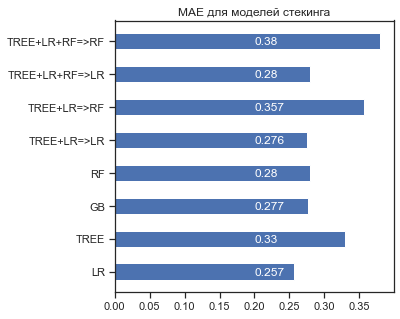

In [43]:
# Визуализация результатов
vis_models_quality(array_mae, array_labels, 'MAE для моделей стекинга')

Вывод: лучший результат стекинга сравним с наиболее сильной моделью 1 уровня (логистической регрессией).